In [1]:
import os
GPU_id = 1
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import warnings
warnings.filterwarnings("ignore")
import cudf as gd
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import time
import nvstrings
from librmm_cffi import librmm
import matplotlib.pyplot as plt
%matplotlib inline

### Global

In [3]:
GPU_RUN_TIME = {}
CPU_RUN_TIME = {}
STEPS = []

### Functions

In [4]:
def on_gpu(words,func,arg=None,dtype=np.int32):
    res = librmm.device_array(words.size(), dtype=dtype)
    if arg is None:
        cmd = 'words.%s(res.device_ctypes_pointer.value)'%(func)
    else:
        cmd = 'words.%s(arg,res.device_ctypes_pointer.value)'%(func)
    eval(cmd)
    return res

### Read data

In [5]:
if os.path.exists('cache')==False:
    os.mkdir('cache')

In [6]:
path = '/datasets/trivago/data/'

In [7]:
step = 'read csv'
STEPS.append(step)

### cudf read csv

In [8]:
%%time
start = time.time()
train_gd = gd.read_csv('%s/train.csv'%path)
test_gd = gd.read_csv('%s/test.csv'%path)
submission_gd = gd.read_csv('%s/submission_popular.csv'%path)
print("train & test",train_gd.shape,test_gd.shape)
data_gd = gd.concat([train_gd,test_gd])
print('combined',data_gd.shape)
GPU_RUN_TIME[step] = time.time() - start

train & test (15932992, 12) (3782335, 12)
combined (19715327, 12)
CPU times: user 3.74 s, sys: 1.48 s, total: 5.22 s
Wall time: 5.24 s


### pandas read csv

In [9]:
%%time
start = time.time()
train_pd = pd.read_csv('%s/train.csv'%path)
test_pd = pd.read_csv('%s/test.csv'%path)
submission_pd = pd.read_csv('%s/submission_popular.csv'%path)
print("train & test",train_pd.shape,test_pd.shape)
data_pd = pd.concat([train_pd,test_pd])
print('combined',data_pd.shape)
CPU_RUN_TIME[step] = time.time() - start

train & test (15932992, 12) (3782335, 12)
combined (19715327, 12)
CPU times: user 1min 30s, sys: 10.4 s, total: 1min 41s
Wall time: 57.6 s


In [10]:
del train_gd,test_gd
del train_pd,test_pd

### Only keep click out rows

In [11]:
step = 'string comparsion and masking'
STEPS.append(step)

### cudf string comparsion and masking

In [12]:
%%time
start = time.time()
data_gd['is_click_out'] = on_gpu(data_gd['action_type'].data,'compare',arg='clickout item')
data_gd['is_click_out'] = data_gd['is_click_out']==0 # 0 means string match
data_gd['is_click_out'] = data_gd['is_click_out'].astype('bool')
data_gd = data_gd[data_gd['is_click_out']]

data_gd.drop_column('is_click_out')
print("# of clickouts:",data_gd.shape[0])
data_gd['clickout_missing'] = data_gd['reference'].isnull()

print('true test',data_gd[data_gd['clickout_missing']].shape)
assert submission_gd.shape[0] == data_gd[data_gd['clickout_missing']].shape[0]
print('true test shape match submission shape')
GPU_RUN_TIME[step] = time.time() - start

# of clickouts: 2115365
true test (253573, 13)
true test shape match submission shape
CPU times: user 2.24 s, sys: 780 ms, total: 3.02 s
Wall time: 3.04 s


### pandas string comparsion and masking

In [13]:
%%time
start = time.time()
data_pd['is_click_out'] = data_pd['action_type']=='clickout item'
data_pd = data_pd[data_pd['is_click_out']]

data_pd.drop('is_click_out',axis=1,inplace=True)
print("# of clickouts:",data_pd.shape[0])
data_pd['clickout_missing'] = data_pd['reference'].isnull()

print('true test',data_pd[data_pd['clickout_missing']].shape)
assert submission_pd.shape[0] == data_pd[data_pd['clickout_missing']].shape[0]
print('true test shape match submission shape')
CPU_RUN_TIME[step] = time.time() - start

# of clickouts: 2115365
true test (253573, 13)
true test shape match submission shape
CPU times: user 21.5 s, sys: 4.49 s, total: 25.9 s
Wall time: 14.8 s


In [14]:
%%time
data_gd['row_id'] = np.arange(data_gd.shape[0])
data_pd['row_id'] = np.arange(data_pd.shape[0])

CPU times: user 692 ms, sys: 24 ms, total: 716 ms
Wall time: 19.1 ms


### Create recommendation list from `impressions`

In [15]:
step = 'string column split & expand'
STEPS.append(step)

### cudf string column split and expand

In [16]:
%%time
start = time.time()
# impressions/prices will be split into 25 columns
candidates_gd = data_gd['impressions'].data.split('|')
prices_gd = data_gd['prices'].data.split('|')
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 6.7 s, sys: 812 ms, total: 7.51 s
Wall time: 614 ms


### pandas string column split and expand

In [17]:
%%time
start = time.time()
candidates_pd = data_pd['impressions'].str.split("|", expand = True) 
prices_pd = data_pd['prices'].str.split("|", expand = True) 
CPU_RUN_TIME[step] = time.time() - start

CPU times: user 1min 17s, sys: 6.27 s, total: 1min 23s
Wall time: 1min 10s


In [18]:
%%time
data_gd.drop_column('impressions')
data_gd.drop_column('prices')
data_pd.drop('impressions',axis=1,inplace=True)
data_pd.drop('prices',axis=1,inplace=True)

CPU times: user 7.24 s, sys: 864 ms, total: 8.11 s
Wall time: 663 ms


### Assign string columns to dataframe

In [19]:
step = 'assign string columns to dataframe'
STEPS.append(step)

In [20]:
%%time
start = time.time()
data_gd_rec_list = data_gd[['row_id']].to_pandas()
for i in range(len(candidates_gd)):
    data_gd_rec_list['item_%d'%i] = candidates_gd[i].to_host()
    data_gd_rec_list['price_%d'%i] = prices_gd[i].to_host()
data_gd_rec_list = data_gd_rec_list.set_index('row_id')
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 33.8 s, sys: 7.7 s, total: 41.5 s
Wall time: 26.8 s


In [21]:
%%time
start = time.time()
data_pd_rec_list = data_pd[['row_id']]
for i in range(candidates_pd.shape[1]):
    data_pd_rec_list['item_%d'%i] = candidates_pd[i]
    data_pd_rec_list['price_%d'%i] = prices_pd[i]
data_pd_rec_list = data_pd_rec_list.set_index('row_id')
CPU_RUN_TIME[step] = time.time() - start

CPU times: user 46.4 s, sys: 5.17 s, total: 51.6 s
Wall time: 44.2 s


### Create data pair

In [22]:
step = 'create data pair'
STEPS.append(step)

### cudf create data pair
For functionalities that are not supported by cudf yet, such as `stack`, we fall back to pandas. 

In [23]:
%%time
start = time.time()

cols = [i for i in data_gd_rec_list.columns if i.startswith('item_')]
items = data_gd_rec_list[cols].stack().reset_index()
items.columns = ['row_id','candidate_order','item_id']

cols = [i for i in data_gd_rec_list.columns if i.startswith('price_')]
prices = data_gd_rec_list[cols].stack().reset_index()
prices.columns = ['row_id','candidate_order','price']

items['price'] = prices['price'].astype(int)
items['candidate_order'] = items['candidate_order'].apply(lambda x:x.split('_')[1]).astype(int)

count = items['row_id'].value_counts()
items['row_id_count'] = items['row_id'].map(count)
items = items[items['row_id_count']>1]
items_gd = gd.from_pandas(items)

data_gd['clickout_missing'] = data_gd['clickout_missing'].astype(int)
data_pair_gd = items_gd.merge(data_gd,on='row_id',how='left')

data_pair_gd['reference'] = data_pair_gd['reference'].astype(int)
data_pair_gd['item_id'] = data_pair_gd['item_id'].astype(int)
data_pair_gd['target'] = data_pair_gd['reference'] == data_pair_gd['item_id']
data_pair_gd['target'] = data_pair_gd['target'].astype(int)

GPU_RUN_TIME[step] = time.time() - start

CPU times: user 2min 42s, sys: 30.4 s, total: 3min 12s
Wall time: 1min 29s


In [24]:
%%time
start = time.time()

cols = [i for i in data_pd_rec_list.columns if i.startswith('item_')]
items = data_pd_rec_list[cols].stack().reset_index()
items.columns = ['row_id','candidate_order','item_id']

cols = [i for i in data_pd_rec_list.columns if i.startswith('price_')]
prices = data_pd_rec_list[cols].stack().reset_index()
prices.columns = ['row_id','candidate_order','price']

items['price'] = prices['price'].astype(int)
items['candidate_order'] = items['candidate_order'].apply(lambda x:x.split('_')[1]).astype(int)

count = items['row_id'].value_counts()
items['row_id_count'] = items['row_id'].map(count)
items = items[items['row_id_count']>1]

data_pd['clickout_missing'] = data_pd['clickout_missing'].astype(int)
data_pair_pd = items.merge(data_pd,on='row_id',how='left')

data_pair_pd['reference'] = data_pair_pd['reference'].fillna(-1).astype(int)
data_pair_pd['item_id'] = data_pair_pd['item_id'].fillna(-1).astype(int)
data_pair_pd['target'] = data_pair_pd['reference'] == data_pair_pd['item_id']
data_pair_pd['target'] = data_pair_pd['target'].astype(int)

CPU_RUN_TIME[step] = time.time() - start

CPU times: user 3min 34s, sys: 45.1 s, total: 4min 19s
Wall time: 1min 57s


### Visualize the timing

In [27]:
GPU_RUN_TIME['Overall'] = sum([GPU_RUN_TIME[i] for i in STEPS])
CPU_RUN_TIME['Overall'] = sum([CPU_RUN_TIME[i] for i in STEPS])
STEPS.append('Overall')

timing = pd.DataFrame()
timing['step'] = STEPS
timing['GPU'] = [GPU_RUN_TIME[i] for i in STEPS]
timing['CPU'] = [CPU_RUN_TIME[i] for i in STEPS]
timing

,step,GPU,CPU
0,read csv,5.236530,57.576515
1,string comparsion and masking,3.042940,14.772895
2,string column split & expand,0.614177,70.012572
3,assign string columns to dataframe,26.808215,44.185446
4,create data pair,89.859261,117.327982
5,Overall,125.561122,303.875410


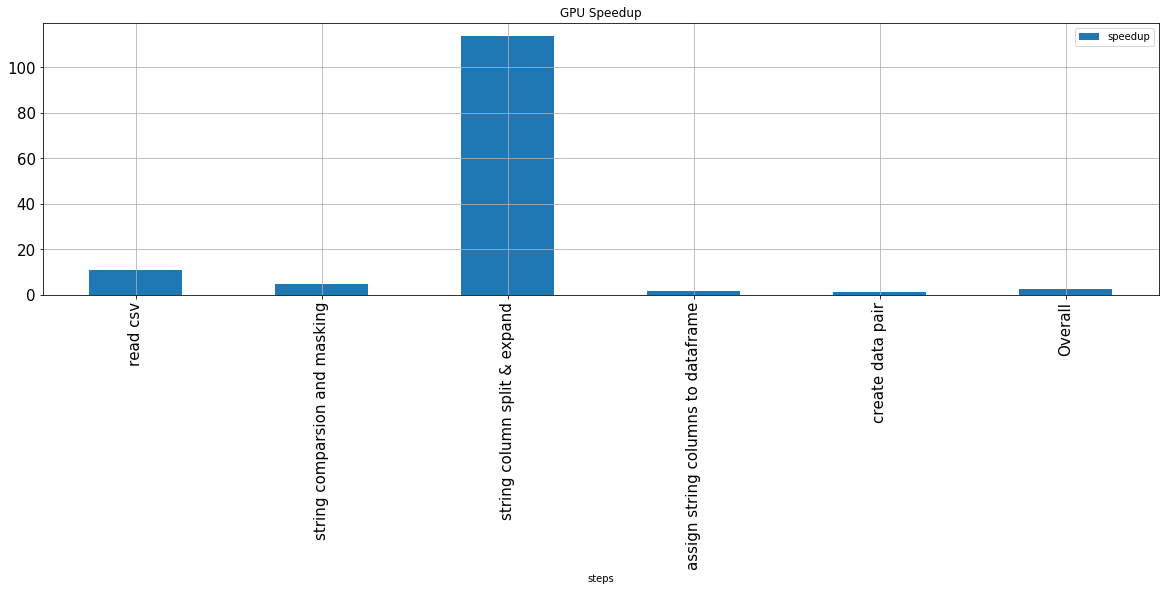

In [31]:
speedup = [CPU_RUN_TIME[i]/GPU_RUN_TIME[i] for i in STEPS]
df = pd.DataFrame({'steps':STEPS, 'speedup':speedup})
ax = df.plot.bar(x='steps', y='speedup', figsize=(20,5), fontsize=15, title='GPU Speedup',grid=True)

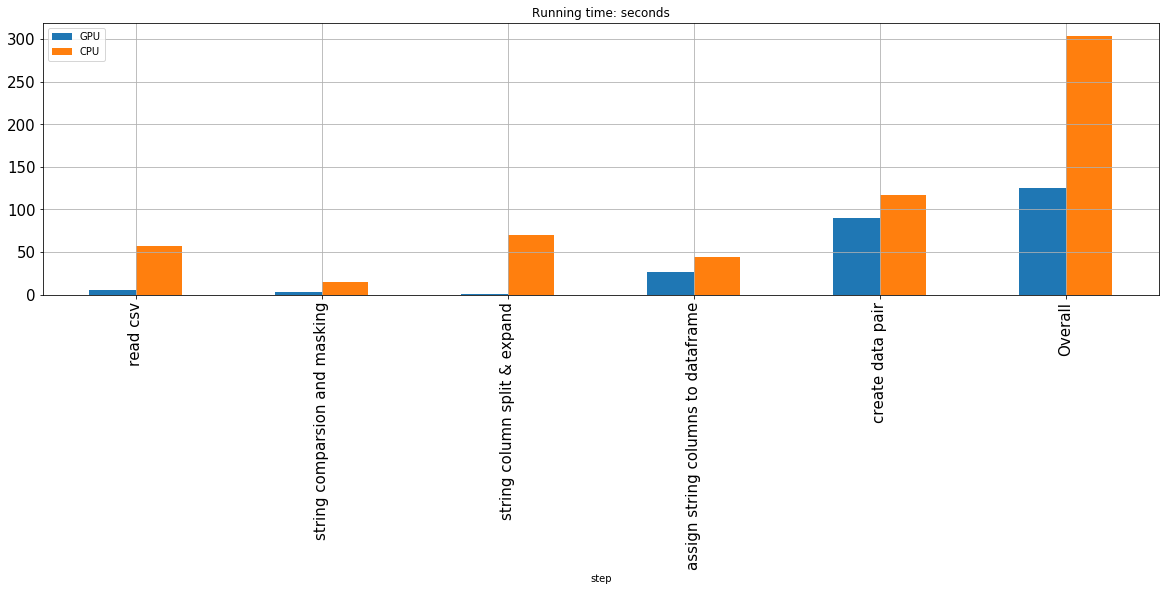

In [35]:
timing.set_index('step').plot.bar(figsize=(20,5),grid=True,fontsize=15, title='Running time: seconds')